In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor as XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Import Dataset

In [11]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [12]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.125, n_splits=2, random_state=7)
split = splitter.split(train, groups=train['site_no'])
train_idx, val_idx = next(split)

train_ = train.iloc[train_idx]
val_ = train.iloc[val_idx]

In [13]:
X_train_ = train_.drop(columns=['site_no', 'mean_depth_va'])
X_val_ = val_.drop(columns=['site_no', 'mean_depth_va'])

y_train_ = train_[['mean_depth_va']]
y_val_ = val_[['mean_depth_va']]

In [18]:
# http://hyperopt.github.io/hyperopt/getting-started/search_spaces/#defining-a-search-space
space={
    'max_depth': hp.quniform("max_depth", 2, 10, 1),
    # 'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    # 'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200])
    }

In [19]:
def objective(space):
    model=XGBRegressor(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        n_estimators = space['n_estimators']
    )

    model.fit(X_train_.to_numpy(), y_train_.to_numpy().ravel())

    pred = model.predict(X_val_.to_numpy())
    accuracy = r2_score(y_val_, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [20]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [17:34<00:00, 10.55s/trial, best loss: -0.9880855759814661]


In [21]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'learning_rate': 0.14264219278216356, 'max_depth': 3.0, 'n_estimators': 2}


In [29]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [26]:
xgb = XGBRegressor(max_depth=3, learning_rate=0.14264219278216356, n_estimators=400, random_state=42)

In [27]:
xgb.fit(X_train, y_train)

C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.14264219278216356, n_estimators=400,
                          random_state=42)

In [32]:
import pickle

with open('./data/ml_weights/xgb_best_model', "wb") as fp:
    pickle.dump(xgb, fp)

In [10]:
import pickle

with open('./data/ml_weights/xgb_best_model', "rb") as fp:
    xgb = pickle.load(fp)

NSE: 0.9808, R2: 0.9813, PBias: 0.3015, MSE: 0.8548


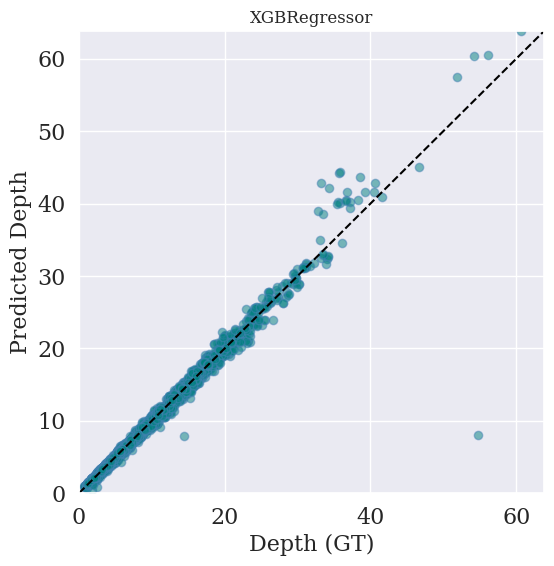

In [30]:
y_pred = xgb.predict(X_test)
scatter_plot(y_test, y_pred, model_name='XGBRegressor')